In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [20]:
train = pd.read_csv('data/train.csv')
train['datetime'] = pd.to_datetime(train['datetime'], utc=True)
train['hour'] = train['datetime'].dt.hour

# Join electricity prices with training target by data_block_id and hour of day
electricity = pd.read_csv('data/electricity_prices.csv')
electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'], utc=True)
electricity['hour'] = electricity['forecast_date'].dt.hour
dataset = train.merge(electricity[['euros_per_mwh', 'hour', 'data_block_id']], how='left', on=['hour', 'data_block_id'])

# Join gas prices with training target by data_block_id
gas = pd.read_csv('data/gas_prices.csv')
dataset = dataset.merge(gas[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']], how='left', on='data_block_id')

# Join client types by data_block_id
client = pd.read_csv('data/client.csv')
client['data_block_id'] -= 2 # Client data_block_id seems to be ahead by 2 for the same days
dataset = dataset.merge(client.drop(columns = ['date']), how='left', on=['data_block_id', 'county', 'is_business', 'product_type'])

print(dataset.info())

dataset.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 15 columns):
 #   Column                 Dtype              
---  ------                 -----              
 0   county                 int64              
 1   is_business            int64              
 2   product_type           int64              
 3   target                 float64            
 4   is_consumption         int64              
 5   datetime               datetime64[ns, UTC]
 6   data_block_id          int64              
 7   row_id                 int64              
 8   prediction_unit_id     int64              
 9   hour                   int32              
 10  euros_per_mwh          float64            
 11  lowest_price_per_mwh   float64            
 12  highest_price_per_mwh  float64            
 13  eic_count              float64            
 14  installed_capacity     float64            
dtypes: datetime64[ns, UTC](1), float64(6), int32(1), int64(7)
memory u

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,hour,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity
0,0,0,1,0.713,0,2021-09-01 00:00:00+00:00,0,0,0,0,NaN,NaN,NaN,108.0,952.89
1,0,0,1,96.590,1,2021-09-01 00:00:00+00:00,0,1,0,0,NaN,NaN,NaN,108.0,952.89
2,0,0,2,0.000,0,2021-09-01 00:00:00+00:00,0,2,1,0,NaN,NaN,NaN,17.0,166.40
3,0,0,2,17.314,1,2021-09-01 00:00:00+00:00,0,3,1,0,NaN,NaN,NaN,17.0,166.40
4,0,0,3,2.904,0,2021-09-01 00:00:00+00:00,0,4,2,0,NaN,NaN,NaN,688.0,7207.88


In [21]:
weather_map = pd.read_csv('input/weather_station_to_county_mapping.csv')
forecast_weather = pd.read_csv('data/forecast_weather.csv')
historical_weather = pd.read_csv('data/historical_weather.csv')



# Round longitude and latitude to nearest decimal
weather_map[['latitude', 'longitude']] = weather_map[['latitude', 'longitude']].astype(float).round(1)
forecast_weather[['latitude', 'longitude']] = forecast_weather[['latitude', 'longitude']].astype(float).round(1)
historical_weather[['latitude', 'longitude']] = historical_weather[['latitude', 'longitude']].astype(float).round(1)

# Join county id to weather forecast via longitude and latitude
forecast_weather = forecast_weather.merge(weather_map[['longitude', 'latitude', 'county']], how='left', on=['longitude', 'latitude'])
historical_weather = historical_weather.merge(weather_map[['longitude', 'latitude', 'county']], how='left', on=['longitude', 'latitude'])

# Drop NaNs that come from stations without county mapping and missing entries in weather
forecast_weather.dropna(axis=0, inplace=True) 
historical_weather.dropna(axis=0, inplace=True)


### Prepare forecast weather for join with training data by forecast_datetime
forecast_weather['county'] = forecast_weather['county'].astype('int64')

# Dropping the columns we don't need
forecast_weather.drop(['origin_datetime', 'latitude','longitude', 'hours_ahead', 'data_block_id'], axis=1, inplace= True)

forecast_weather.rename(columns={'forecast_datetime': 'datetime'}, inplace= True)
forecast_weather['datetime']= pd.to_datetime(forecast_weather['datetime'], utc= True)

# Take the mean of forecasts within the same hour across all stations
forecast_weather_datetime = forecast_weather.groupby([forecast_weather['datetime'].dt.to_period('h')])[list(forecast_weather.drop(['county','datetime'], axis= 1).columns)].mean().reset_index()
forecast_weather_datetime['datetime']= pd.to_datetime(forecast_weather_datetime['datetime'].dt.to_timestamp(), utc=True)

# Take the mean of forecasts of stations within the same county
forecast_weather_datetime_county= forecast_weather.groupby(['county',forecast_weather['datetime'].dt.to_period('h')])[list(forecast_weather.drop(['county','datetime'], axis= 1).columns)].mean().reset_index()
forecast_weather_datetime_county['datetime']= pd.to_datetime(
forecast_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)


### Prepare historical weather for join with training data by data_block_id and hour of day
historical_weather['county'] = historical_weather['county'].astype('int64')

# Dropping the columns we don't need
historical_weather.drop(['latitude','longitude'], axis=1, inplace= True)

historical_weather['datetime']= pd.to_datetime(historical_weather['datetime'], utc= True)

# Take the mean of values within the same hour across all stations
historical_weather_datetime = historical_weather.groupby([historical_weather['datetime'].dt.to_period('h')])[list(historical_weather.drop(['county','datetime'], axis= 1).columns)].mean().reset_index()
historical_weather_datetime['datetime']= pd.to_datetime(historical_weather_datetime['datetime'].dt.to_timestamp(), utc=True)

# Take the mean of forecasts of stations within the same county
historical_weather_datetime_county= historical_weather.groupby(['county',historical_weather['datetime'].dt.to_period('h')])[list(historical_weather.drop(['county','datetime'], axis= 1).columns)].mean().reset_index()
historical_weather_datetime_county['datetime']= pd.to_datetime(
historical_weather_datetime_county['datetime'].dt.to_timestamp(), utc=True)


/tmp/ipykernel_10688/3926131237.py:31: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  forecast_weather_datetime = forecast_weather.groupby([forecast_weather['datetime'].dt.to_period('h')])[list(forecast_weather.drop(['county','datetime'], axis= 1).columns)].mean().reset_index()
/tmp/ipykernel_10688/3926131237.py:35: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  forecast_weather_datetime_county= forecast_weather.groupby(['county',forecast_weather['datetime'].dt.to_period('h')])[list(forecast_weather.drop(['county','datetime'], axis= 1).columns)].mean().reset_index()
/tmp/ipykernel_10688/3926131237.py:49: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  historical_weather_datetime = historical_weather.groupby([historical_weather['datetime'].dt.to_period('h')])[list(historical_weather.drop(['county','datetime'], axis= 1).columns)].mean().reset_index()

In [22]:
# Join weather data with training target
dataset = dataset.merge(forecast_weather_datetime_county, how='left', on=['datetime', 'county'])

historical_weather_datetime_county['hour']= historical_weather_datetime_county['datetime'].dt.hour
historical_weather_datetime_county.drop('datetime', axis= 1, inplace= True)
dataset = dataset.merge(historical_weather_datetime_county, how='left', on=['data_block_id', 'county', 'hour'])



In [5]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
county,2018352.0,7.297034e+00,4.780990,0.000000,3.000000,7.000000e+00,1.100000e+01,1.500000e+01
is_business,2018352.0,5.368261e-01,0.498642,0.000000,0.000000,1.000000e+00,1.000000e+00,1.000000e+00
product_type,2018352.0,1.898927e+00,1.081766,0.000000,1.000000,2.000000e+00,3.000000e+00,3.000000e+00
target,2017824.0,2.748556e+02,909.502378,0.000000,0.378000,3.113300e+01,1.802062e+02,1.548027e+04
is_consumption,2018352.0,5.000000e-01,0.500000,0.000000,0.000000,5.000000e-01,1.000000e+00,1.000000e+00
data_block_id,2018352.0,3.218746e+02,182.634314,0.000000,166.000000,3.230000e+02,4.790000e+02,6.370000e+02
row_id,2018352.0,1.009176e+06,582648.179597,0.000000,504587.750000,1.009176e+06,1.513763e+06,2.018351e+06
prediction_unit_id,2018352.0,3.304538e+01,19.590594,0.000000,16.000000,3.300000e+01,5.000000e+01,6.800000e+01
hour,2018352.0,1.150000e+01,6.922188,0.000000,5.750000,1.150000e+01,1.725000e+01,2.300000e+01
euros_per_mwh,2015156.0,1.574218e+02,121.330608,-10.060000,85.290000,1.286600e+02,1.999600e+02,4.000000e+03


In [6]:
dataset.head(10)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,hour,...,surface_pressure,cloudcover_total_y,cloudcover_low_y,cloudcover_mid_y,cloudcover_high_y,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation_y,diffuse_radiation
0,0,0,1,0.713,0,2021-09-01 00:00:00+00:00,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00+00:00,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00+00:00,0,2,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00+00:00,0,3,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00+00:00,0,4,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,0,3,656.859,1,2021-09-01 00:00:00+00:00,0,5,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,1,0,0.000,0,2021-09-01 00:00:00+00:00,0,6,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,1,0,59.000,1,2021-09-01 00:00:00+00:00,0,7,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,1,1,0.000,0,2021-09-01 00:00:00+00:00,0,8,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,1,1,501.760,1,2021-09-01 00:00:00+00:00,0,9,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


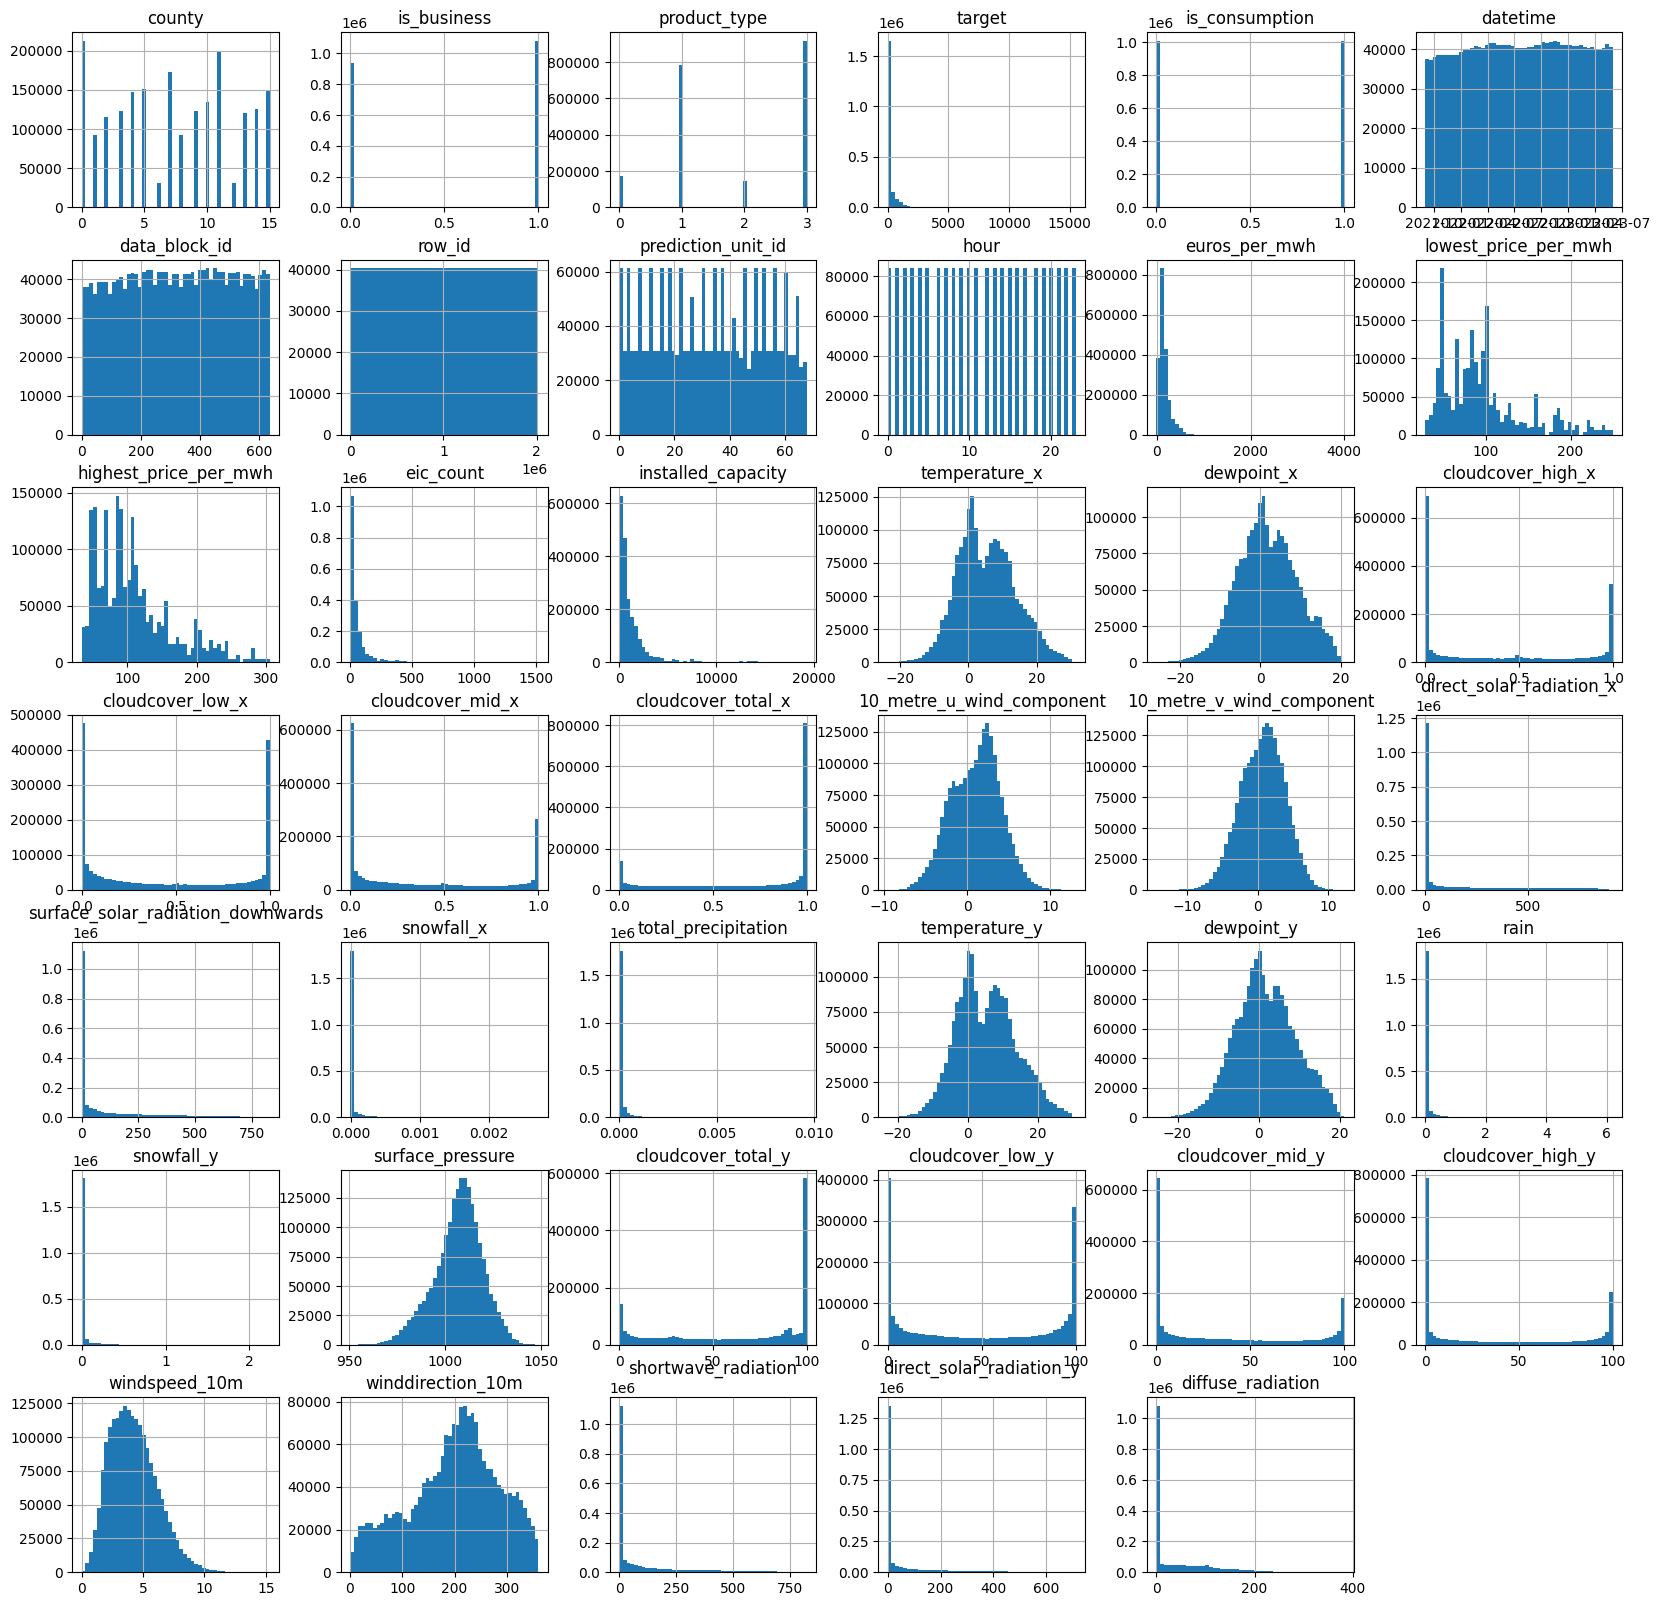

In [14]:
dataset.hist(bins=50, figsize=(20,20))
plt.show()

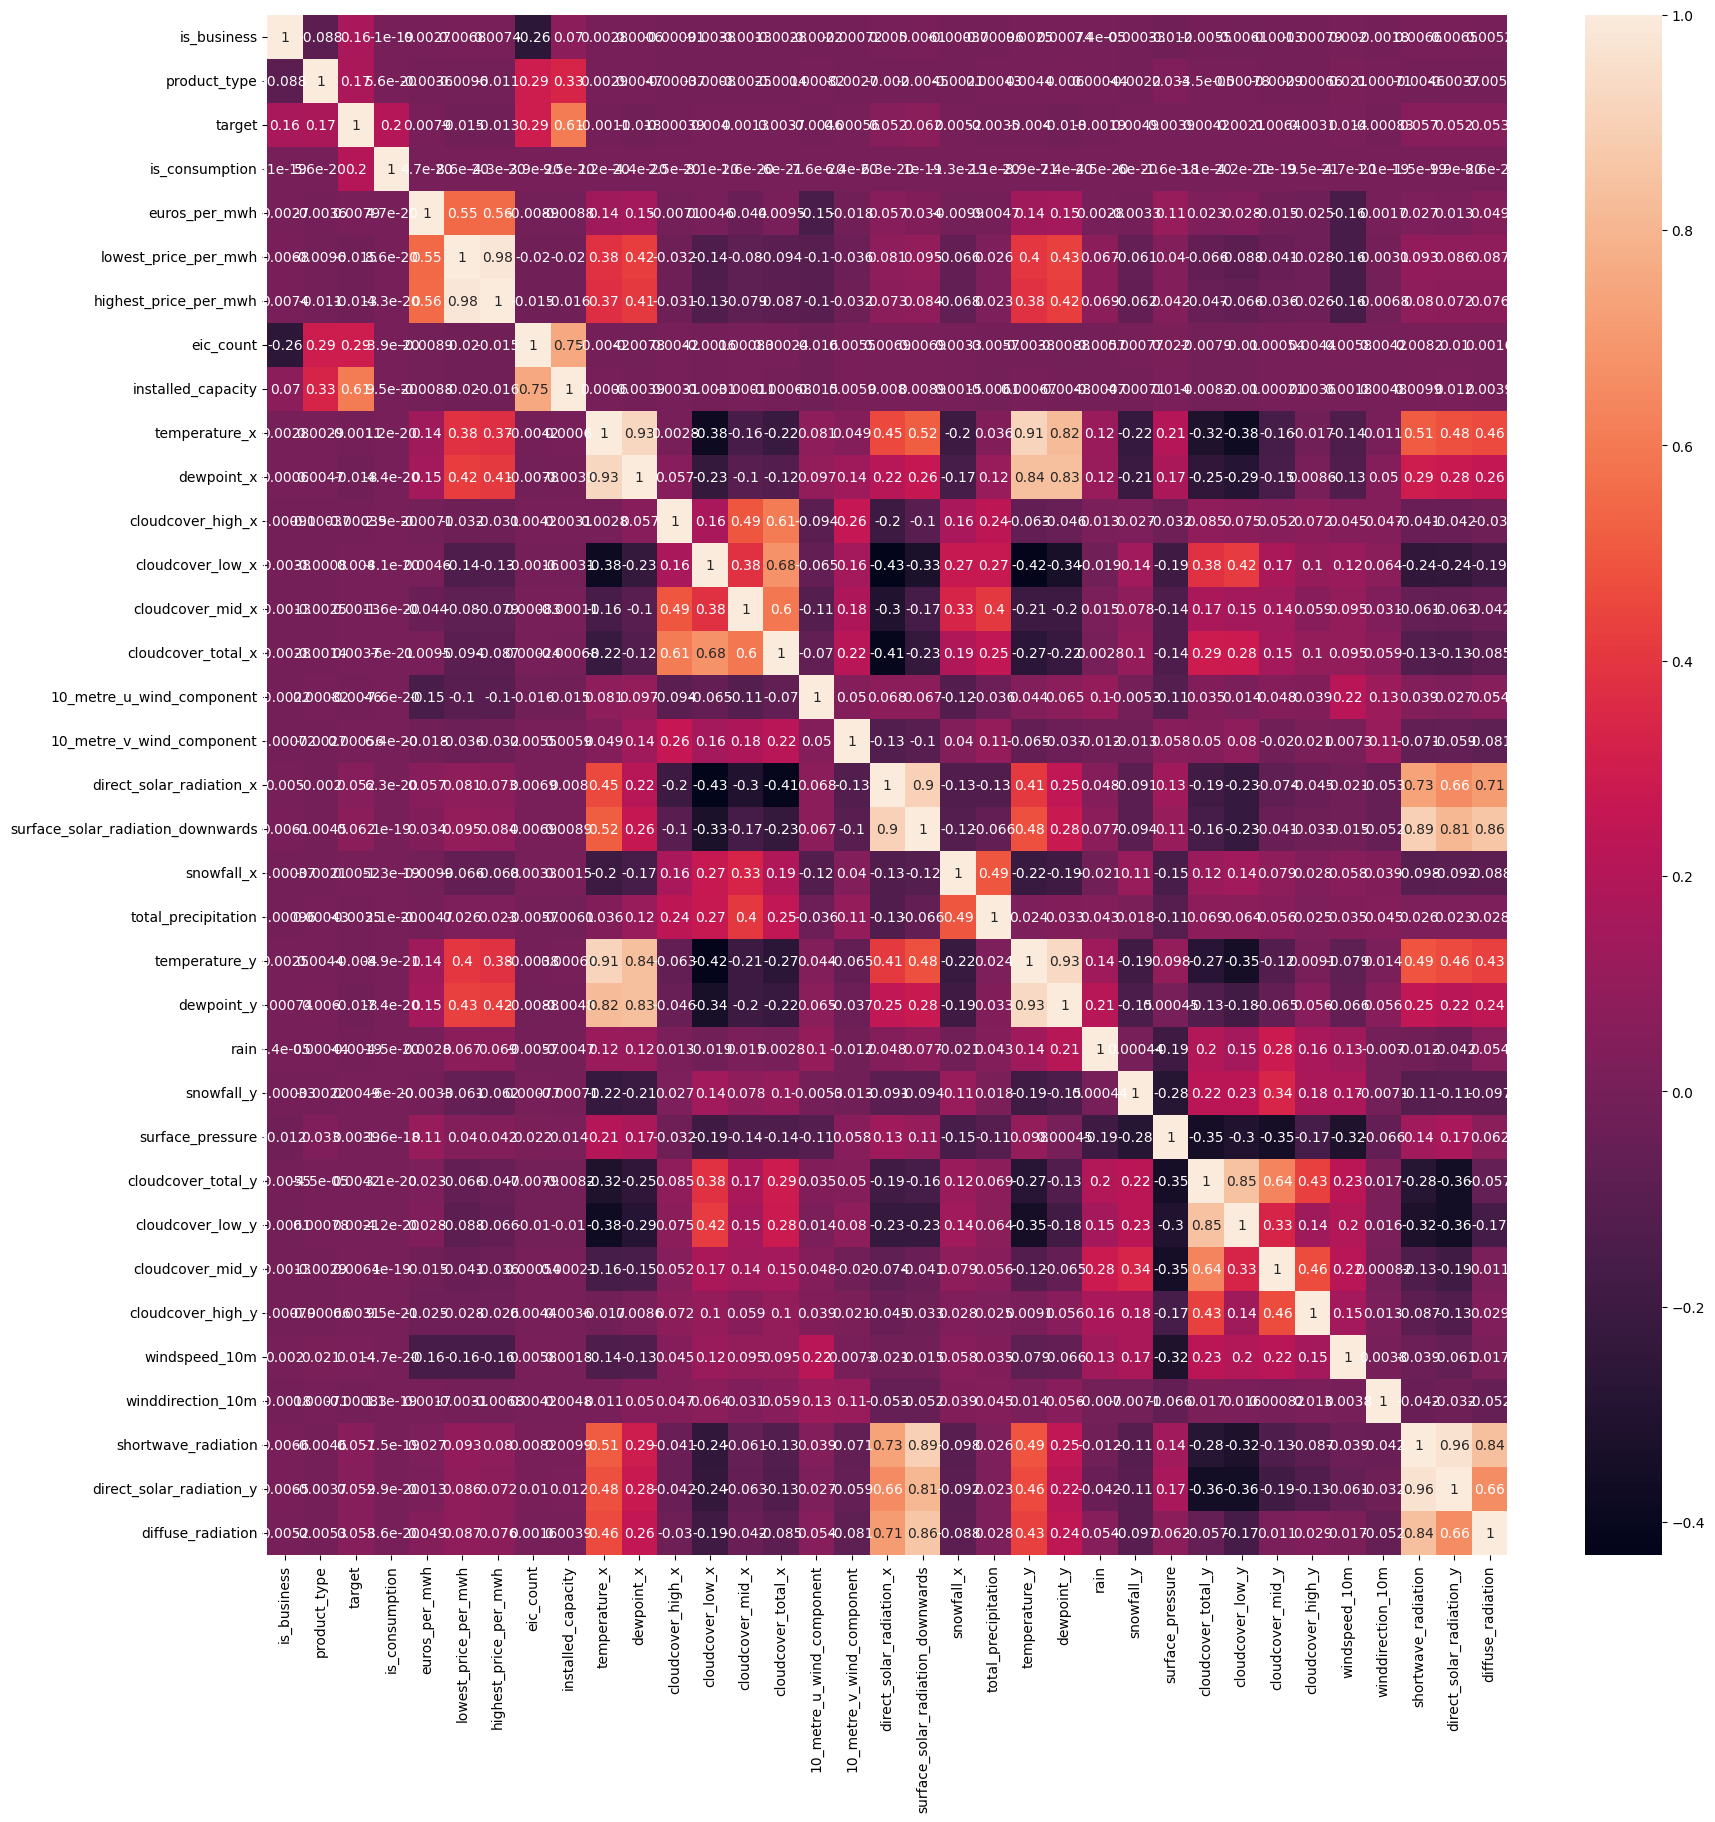

In [23]:
corr_matrix = dataset.drop(['datetime', 'data_block_id', 'row_id', 'prediction_unit_id', 'hour', 'county'], axis=1).corr()
corr_plot , corr_ax = plt.subplots(figsize=(20,20))

sns.heatmap(data=corr_matrix, annot=True, ax=corr_ax)

plt.show()


/tmp/ipykernel_10688/3794970416.py:14: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  fig = sns.lineplot(df_plot, x="datetime", y="target", hue='product_type', palette=palette)


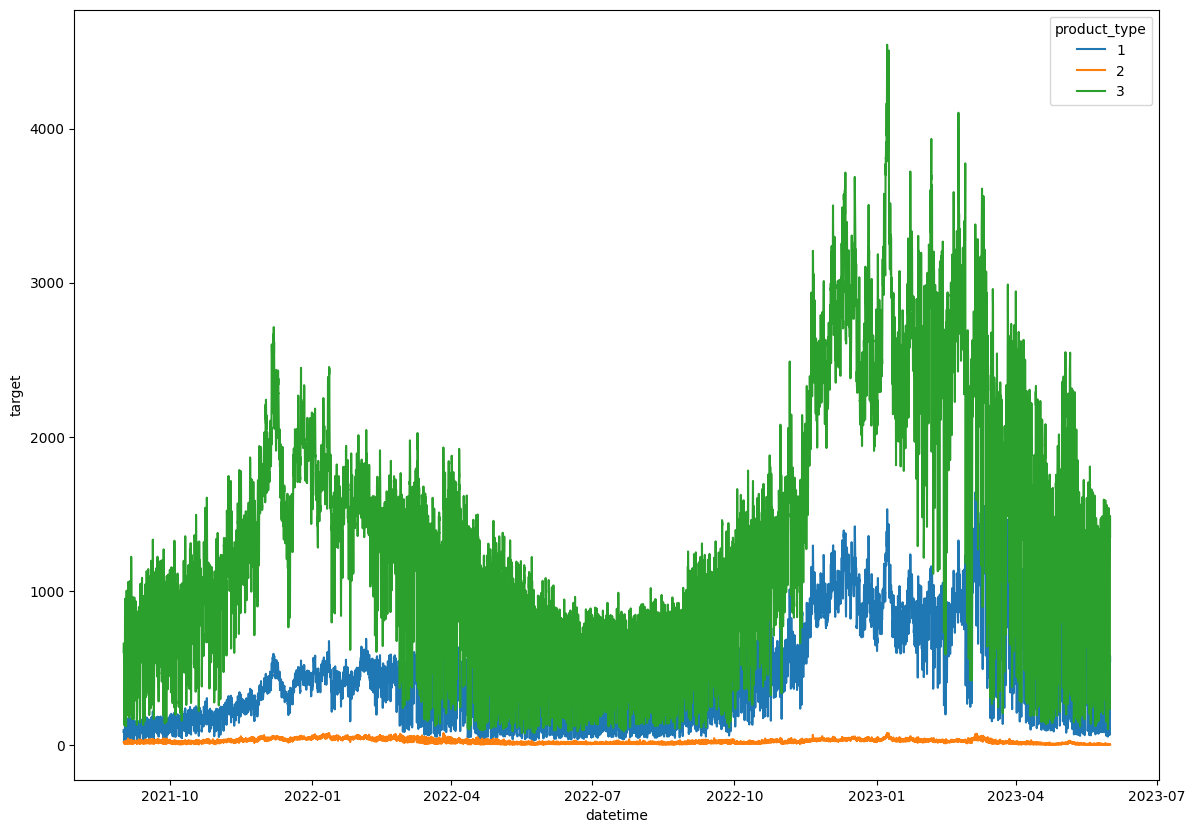

In [35]:
county = 0
is_business = 0
is_consumption = 1

df_plot = dataset[['county', 'is_consumption', 'is_business', 'target', 'datetime', 'product_type']]

df_plot = df_plot[
    (dataset['county'] == county)
    & (dataset['is_business'] == is_business)
    & (dataset['is_consumption'] == is_consumption)]

palette = sns.color_palette("tab10")
plt.figure(figsize=(14,10))
fig = sns.lineplot(df_plot, x="datetime", y="target", hue='product_type', palette=palette)

plt.show()